# Visualization of neural activations of agent by t-SNE

In [1]:
import gym
from gym import spaces
from gym.utils import seeding
from gym.envs.registration import register

from custom_functions.custom_functions import env_fn 
from custom_functions.custom_functions import test_agent
from custom_functions.custom_functions import plot_test

import spinup

from os import path
from scipy.integrate import solve_ivp
import random
import torch
import torch.nn as nn
import numpy as np
from collections import deque
import matplotlib.pyplot as plt
%matplotlib inline
#from vpython import *
from functools import partial
from sklearn.manifold import TSNE
register(id='gyroscopeenv-v0',entry_point='gym_GyroscopeEnv.envs:GyroscopeEnv')
register(id='gyroscoperobustenv-v0',entry_point='gym_GyroscopeEnv.envs:GyroscopeRobustEnv')
register(id='gyroscopeintegralenv-v0',entry_point='gym_GyroscopeEnv.envs:GyroscopeIntegralEnv')

In [2]:
from matplotlib import rcParams
rcParams['font.family'] = 'arial'


In [3]:
# Load env
def env_fn(env_name = 'gyroscopeenv-v0', reward_type = None, reward_args = None, ep_len = None, is_noise=False):
    if reward_type is not None:
        env = gym.make(env_name)
        env.args_init(reward_type, reward_args, ep_len, is_noise)
        return env
    else: return gym.make(env_name)
    
env_name = 'gyroscopeenv-v0'
reward_type = 'Normalized'
reward_args = {'k': 0.05, 'qx2' : 0, 'qx4' : 0, 'pu1':0,'pu2':0}
ep_len = 110
is_noise = False
env_temp = partial(env_fn,env_name,reward_type,reward_args,ep_len, is_noise)
env = env_temp()

# Load best agent 
agent = torch.load('best_agent_robustified/pyt_save/model.pt')
print(agent)

# Create random network with the same structure as a control
control = nn.Sequential(nn.Linear(in_features=9, out_features=700, bias=True),
                     nn.ReLU(),
                     nn.Linear(in_features=700, out_features=70, bias=True),
                     nn.ReLU(),
                     nn.Linear(in_features=70, out_features=10, bias=True),
                     nn.ReLU(),
                     nn.Linear(in_features=10, out_features=2, bias=True),
                     nn.Tanh())
init = True

MLPActorCritic(
  (pi): MLPActor(
    (pi): Sequential(
      (0): Linear(in_features=9, out_features=700, bias=True)
      (1): ReLU()
      (2): Linear(in_features=700, out_features=70, bias=True)
      (3): ReLU()
      (4): Linear(in_features=70, out_features=10, bias=True)
      (5): ReLU()
      (6): Linear(in_features=10, out_features=2, bias=True)
      (7): Tanh()
    )
  )
  (q1): MLPQFunction(
    (q): Sequential(
      (0): Linear(in_features=11, out_features=700, bias=True)
      (1): ReLU()
      (2): Linear(in_features=700, out_features=70, bias=True)
      (3): ReLU()
      (4): Linear(in_features=70, out_features=10, bias=True)
      (5): ReLU()
      (6): Linear(in_features=10, out_features=1, bias=True)
      (7): Identity()
    )
  )
  (q2): MLPQFunction(
    (q): Sequential(
      (0): Linear(in_features=11, out_features=700, bias=True)
      (1): ReLU()
      (2): Linear(in_features=700, out_features=70, bias=True)
      (3): ReLU()
      (4): Linear(in_features=7

/home/matthieulc/Documents/MA2/DRLGyro/resources/drlgyroenv/lib/python3.6/site-packages/gym/logger.py:30: UserWarning: WARN: Box bound precision lowered by casting to float32
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))


## Generate random observations

In [4]:
obs_data = []
state_data = []
disk_speed = []
red_speed = []

for i in range(1000):
    obs = env.reset()
    

    # Red gimbal
    theta = (0*np.pi/180)/np.pi
    obs[0] = np.cos(theta)
    obs[1] = np.sin(theta)
    
    # Blue gimbal fixed
    phi = (20*np.pi/180)/np.pi
    obs[3] = np.cos(phi)
    obs[4] = np.sin(phi)
    obs[5] = 0
    
    # References fixed
    obs[6] = (60*np.pi/180)/np.pi
    obs[7] = phi

    disk_speed.append(obs[-1])
    red_speed.append(obs[2])
    
    obs_data.append(obs)

## Get activations of agent

In [5]:
# Create hook
if not init:
    hook1.remove() # if not the first time, release hook
    hook3.remove()
    hook5.remove()
    
global output1
def hook_fn1(module, input, output):
    global output1
    output1 = output

global output3
def hook_fn3(module, input, output):
    global output3
    output3 = output

global output5
def hook_fn5(module, input, output):
    global output5
    output5 = output
    
hook1 = agent.pi.pi[1].register_forward_hook(hook_fn1)
hook3 = agent.pi.pi[3].register_forward_hook(hook_fn3)
hook5 = agent.pi.pi[5].register_forward_hook(hook_fn5)
init = False

# Get activations
activations1 = []
activations3 = []
activations5 = []
u1 = []
for obs in obs_data:
    obs = torch.as_tensor(obs, dtype=torch.float32)
    act = agent.act(obs)
    u1.append(act[0])
    
    # Module 1 (hid layer 1)
    activation1 = output1.tolist()
    activations1.append(activation1)
    
    # Module 3 (hid layer 2)
    activation3 = output3.tolist()
    activations3.append(activation3)
    
    # Module 5 (hid layer 3)
    activation5 = output5.tolist()
    activations5.append(activation5)
    

## Apply t-SNE to agent activations

In [6]:
tsne1 = TSNE(n_components=2,perplexity=50).fit_transform(activations1)
tx1 = tsne1[:, 0]
ty1 = tsne1[:, 1]

tsne3 = TSNE(n_components=2,perplexity=50).fit_transform(activations3)
tx3 = tsne3[:, 0]
ty3 = tsne3[:, 1]

tsne5 = TSNE(n_components=2,perplexity=50).fit_transform(activations5)
tx5 = tsne5[:, 0]
ty5 = tsne5[:, 1]

findfont: Font family ['arial'] not found. Falling back to DejaVu Sans.
findfont: Font family ['arial'] not found. Falling back to DejaVu Sans.


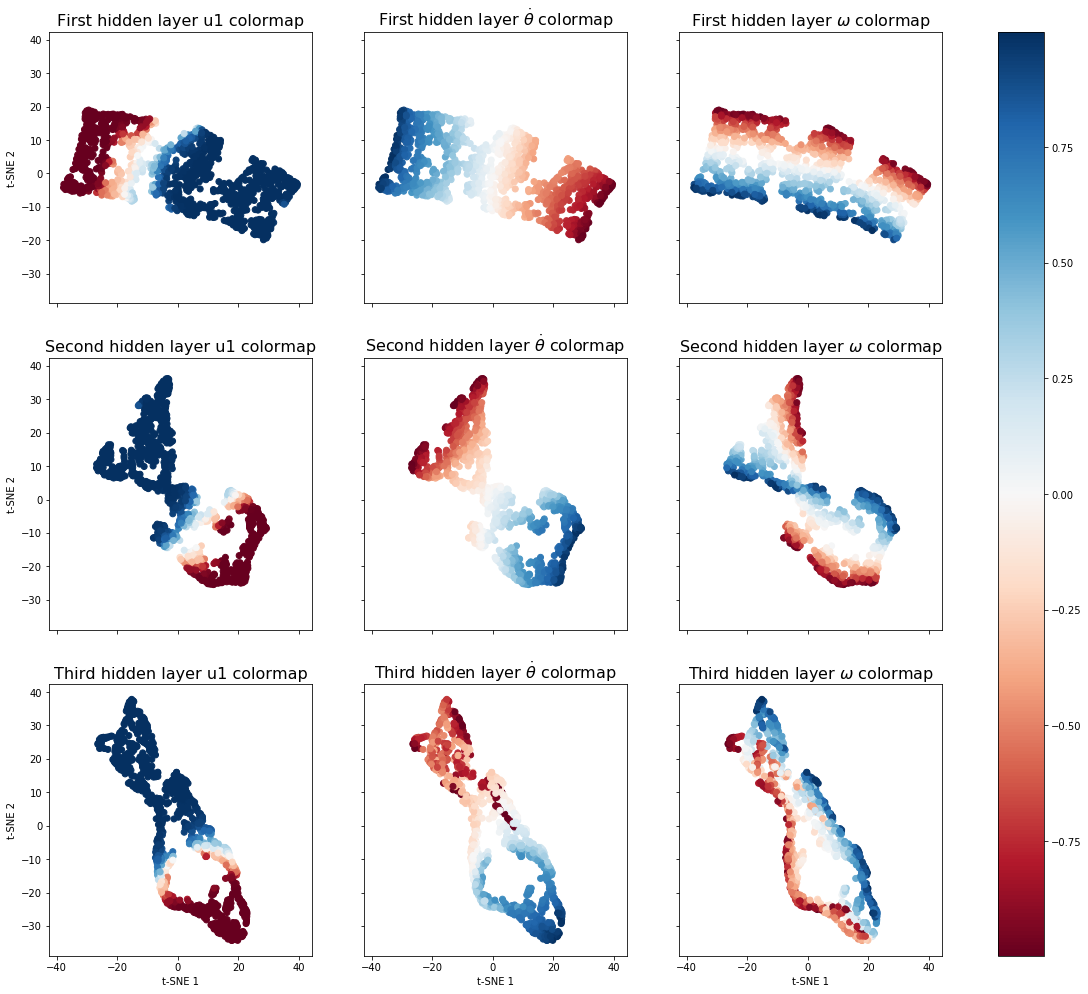

In [7]:
fig, ax = plt.subplots(nrows=3, ncols=3,figsize=(20,17), sharex=True,sharey=True)


sc = ax[0,0].scatter(tx1, ty1,c=u1,cmap='RdBu')
ax[0, 0].set_title('First hidden layer u1 colormap',fontsize=16)
ax[0, 0].set(ylabel='t-SNE 2')
sc = ax[0,1].scatter(tx1, ty1,c=red_speed,cmap='RdBu')
ax[0, 1].set_title(r'First hidden layer $\dot\theta$ colormap',fontsize=16)
sc = ax[0,2].scatter(tx1, ty1,c=disk_speed,cmap='RdBu')
ax[0, 2].set_title(r'First hidden layer $\omega$ colormap',fontsize=16)

sc = ax[1,0].scatter(tx3, ty3,c=u1,cmap='RdBu')
ax[1, 0].set_title('Second hidden layer u1 colormap',fontsize=16)
ax[1, 0].set(ylabel='t-SNE 2')
sc = ax[1,1].scatter(tx3, ty3,c=red_speed,cmap='RdBu')
ax[1, 1].set_title(r'Second hidden layer $\dot\theta$ colormap',fontsize=16)
sc = ax[1,2].scatter(tx3, ty3,c=disk_speed,cmap='RdBu')
ax[1, 2].set_title(r'Second hidden layer $\omega$ colormap',fontsize=16)


sc = ax[2,0].scatter(tx5, ty5,c=u1,cmap='RdBu')
ax[2, 0].set_title('Third hidden layer u1 colormap',fontsize=16)
ax[2, 0].set(xlabel='t-SNE 1',ylabel='t-SNE 2')
sc = ax[2,1].scatter(tx5, ty5,c=red_speed,cmap='RdBu')
ax[2, 1].set_title(r'Third hidden layer $\dot\theta$ colormap',fontsize=16)
ax[2, 1].set(xlabel='t-SNE 1')
sc = ax[2,2].scatter(tx5, ty5,c=disk_speed,cmap='RdBu')
ax[2, 2].set_title(r'Third hidden layer $\omega$ colormap',fontsize=16)
ax[2, 2].set(xlabel='t-SNE 1')

fig.colorbar(sc, ax=ax.ravel().tolist())
plt.show()
fig.savefig('tsneactor.pdf')

## Get activations of control

In [8]:
# Create hook
if not init:
    hook1.remove() # if not the first time, release hook
    hook3.remove()
    hook5.remove()
    
global output1
def hook_fn1(module, input, output):
    global output1
    output1 = output

global output3
def hook_fn3(module, input, output):
    global output3
    output3 = output

global output5
def hook_fn5(module, input, output):
    global output5
    output5 = output
    
hook1 = control[1].register_forward_hook(hook_fn1)
hook3 = control[3].register_forward_hook(hook_fn3)
hook5 = control[5].register_forward_hook(hook_fn5)
init = False

# Get activations
activations1 = []
activations3 = []
activations5 = []
u1 = []
for obs in obs_data:
    obs = torch.as_tensor(obs, dtype=torch.float32)
    act = control(obs)
    u1.append(act[0])
    
    # Module 1 (hid layer 1)
    activation1 = output1.tolist()
    activations1.append(activation1)
    
    # Module 3 (hid layer 2)
    activation3 = output3.tolist()
    activations3.append(activation3)
    
    # Module 5 (hid layer 3)
    activation5 = output5.tolist()
    activations5.append(activation5)
    

## Apply t-SNE to control activations

In [9]:
tsne1 = TSNE(n_components=2,perplexity=50).fit_transform(activations1)
tx1 = tsne1[:, 0]
ty1 = tsne1[:, 1]

tsne3 = TSNE(n_components=2,perplexity=50).fit_transform(activations3)
tx3 = tsne3[:, 0]
ty3 = tsne3[:, 1]

tsne5 = TSNE(n_components=2,perplexity=50).fit_transform(activations5)
tx5 = tsne5[:, 0]
ty5 = tsne5[:, 1]

findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.


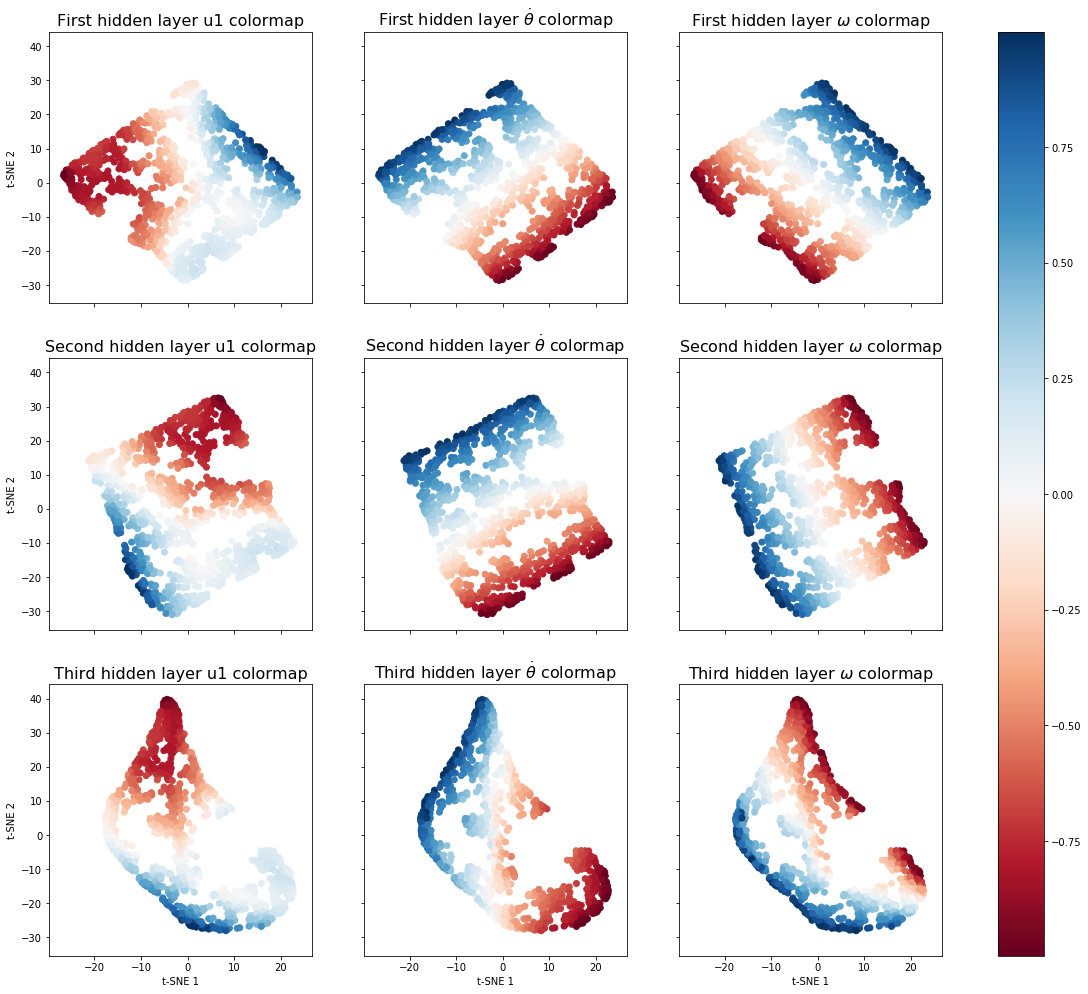

In [10]:
fig, ax = plt.subplots(nrows=3, ncols=3,figsize=(20,17), sharex=True,sharey=True)


sc = ax[0,0].scatter(tx1, ty1,c=u1,cmap='RdBu')
ax[0, 0].set_title('First hidden layer u1 colormap',fontsize=16)
ax[0, 0].set(ylabel='t-SNE 2')
sc = ax[0,1].scatter(tx1, ty1,c=red_speed,cmap='RdBu')
ax[0, 1].set_title(r'First hidden layer $\dot\theta$ colormap',fontsize=16)
sc = ax[0,2].scatter(tx1, ty1,c=disk_speed,cmap='RdBu')
ax[0, 2].set_title(r'First hidden layer $\omega$ colormap',fontsize=16)

sc = ax[1,0].scatter(tx3, ty3,c=u1,cmap='RdBu')
ax[1, 0].set_title('Second hidden layer u1 colormap',fontsize=16)
ax[1, 0].set(ylabel='t-SNE 2')
sc = ax[1,1].scatter(tx3, ty3,c=red_speed,cmap='RdBu')
ax[1, 1].set_title(r'Second hidden layer $\dot\theta$ colormap',fontsize=16)
sc = ax[1,2].scatter(tx3, ty3,c=disk_speed,cmap='RdBu')
ax[1, 2].set_title(r'Second hidden layer $\omega$ colormap',fontsize=16)


sc = ax[2,0].scatter(tx5, ty5,c=u1,cmap='RdBu')
ax[2, 0].set_title('Third hidden layer u1 colormap',fontsize=16, fontname="Arial")
ax[2, 0].set(xlabel='t-SNE 1',ylabel='t-SNE 2')
sc = ax[2,1].scatter(tx5, ty5,c=red_speed,cmap='RdBu')
ax[2, 1].set_title(r'Third hidden layer $\dot\theta$ colormap',fontsize=16, fontname="Arial")
ax[2, 1].set(xlabel='t-SNE 1')
sc = ax[2,2].scatter(tx5, ty5,c=disk_speed,cmap='RdBu')
ax[2, 2].set_title(r'Third hidden layer $\omega$ colormap',fontsize=16, fontname="Arial")
ax[2, 2].set(xlabel='t-SNE 1')

fig.colorbar(sc, ax=ax.ravel().tolist())
plt.show()
fig.savefig('tsnecontrol.pdf')